[*********************100%%**********************]  1 of 1 completed


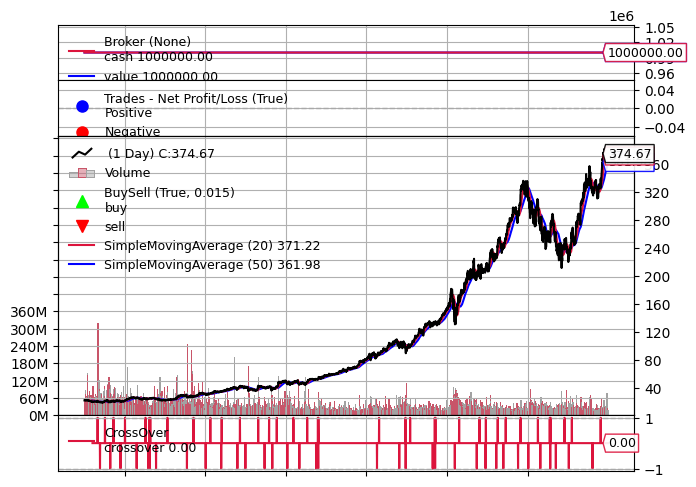

In [69]:
%matplotlib inline
import backtrader as bt
from datetime import datetime
import yfinance as yf
class MovingAverageCrossStrategy(bt.Strategy):

    params = (
        ('fast', 20),
        ('slow', 50),
    )

    def __init__(self):
        self.fast_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.fast
        )
        self.slow_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.slow
        )
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.close()

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MovingAverageCrossStrategy)
    data = bt.feeds.PandasData(dataname=yf.download('MSFT', datetime(2011, 1, 1), datetime(2024, 1, 1), auto_adjust=True))
    cerebro.adddata(data)
    cerebro.broker.setcash(1000000)
    cerebro.addsizer(bt.sizers.SizerFix, stake=3000000)
    cerebro.run()
    cerebro.plot(iplot = False)

In [70]:
cerebro.broker.get_value()

1000000.0

In [48]:
plt.figure(figsize=(10, 6))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
cerebro.plot?

Signature:
cerebro.plot(
    plotter=None,
    numfigs=1,
    iplot=True,
    start=None,
    end=None,
    width=16,
    height=9,
    dpi=300,
    tight=True,
    use=None,
    **kwargs,
)
Docstring:
Plots the strategies inside cerebro

If ``plotter`` is None a default ``Plot`` instance is created and
``kwargs`` are passed to it during instantiation.

``numfigs`` split the plot in the indicated number of charts reducing
chart density if wished

``iplot``: if ``True`` and running in a ``notebook`` the charts will be
displayed inline

``use``: set it to the name of the desired matplotlib backend. It will
take precedence over ``iplot``

``start``: An index to the datetime line array of the strategy or a
``datetime.date``, ``datetime.datetime`` instance indicating the start
of the plot

``end``: An index to the datetime line array of the strategy or a
``datetime.date``, ``datetime.datetime`` instance indicating the end
of the plot

``width``: in inches of the saved figure

``height``: in

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import requests
import json
import os
import time
import pandas as pd
import numpy as np

wd = os.path.abspath("__file__").replace("/__file__", "").replace("notebooks", "")
os.chdir(wd)

import requests
from datetime import datetime, timedelta, date
from logging.handlers import TimedRotatingFileHandler
from src.utils import get_jinja_yaml_conf, create_db_engine, Postgres_connect, send_message_to_discord
from src.api import *
from src.processing import *

now = datetime.now()

In [2]:
conf = get_jinja_yaml_conf('./conf/webhook.yml', './conf/logging.yml', './conf/data.yml')
end_date = datetime.now().date() 

stream = logging.StreamHandler()
stream.setLevel(logging.DEBUG)
# logger 설정
logger = logging.getLogger('main')
logging.basicConfig(level=eval(conf['logging']['level']),
    format=conf['logging']['format'],
    handlers = [TimedRotatingFileHandler(filename =  conf['logging']['file_name'],
                                when=conf['logging']['when'],
                                interval=conf['logging']['interval'],
                                backupCount=conf['logging']['backupCount']), #logging.StreamHandler()
                                   stream]
                )


In [3]:
# Only for notebooks
import re

os.environ['_ts'] = datetime.astimezone(datetime.now()).strftime('%Y-%m-%d %H:%M:%S %z')

with open('./conf/credentials', "r") as file:
    # 각 라인 읽기
    for line in file:
        # 주석(#) 또는 빈 줄은 무시
        if line.strip() == '' or line.startswith('#'):
            continue

        # 각 라인을 '='를 기준으로 key와 value로 분리
        key, value = line.strip().split('=', 1)

        # $ENV 형식의 환경변수가 있을 경우 해당 값을 가져와서 설정
        env_var_pattern = re.compile(r'\$(\w+)')
        matches = env_var_pattern.findall(value)
        for match in matches:
            value = value.replace(f"${match}", os.environ.get(match, "")).replace('"', '')

        # 환경변수로 설정
        os.environ[key] = value

In [4]:
engine = create_db_engine(os.environ)
postgres_conn = Postgres_connect(engine)

2024-08-10 15:50:16,841 (utils.py 75) INFO ::: Connect to 172.20.10.3. DB_NAME is stocks


# Market

In [6]:
full_save = True
market= postgres_conn.get_data('krx', 'idx_market', 
                            columns = ['기준일자', '계열구분 AS 시장구분', '종가', '등락률', '거래량', '거래대금', '상장시가총액 AS 시장시총'],
                              where = ["지수명 IN ('코스피', '코스닥지수')"],
                              orderby_cols = ['시장구분', '기준일자'])

start_date = date(2015, 1, 1) if full_save else market[market['시장구분']=='KOSPI']['기준일자'].sort_values().iloc[-240]
end_date = market[market['시장구분']=='KOSPI']['기준일자'].sort_values().iloc[-240]

market = market[market['기준일자'].map(lambda x: start_date <= x)]
market_dates = market['기준일자'].sort_values().unique()
test_start_date = market_dates[-240]

# Stock

In [7]:
stock_info = postgres_conn.get_data('krx', 'sto_info', 
                      columns = ['기준일자', '단축코드 AS 종목코드', '시장구분', '액면가', '상장주식수'],
                      where = ["증권구분 = '주권'", 
                               "주식종류 = '보통주'", 
                               "시장구분 IN ('KOSPI', 'KOSDAQ')",
                               f"상장일 <= '{end_date}'",
                              f"기준일자 >= '{start_date}'"])

In [8]:
stock_price = postgres_conn.get_data('krx', 'sto_stocks', 
                      columns = ['기준일자', '종목코드', '종가', '등락률', '거래량', '거래대금', '시가총액'],
                      where = [f"종목코드 IN ('{"','".join(stock_info['종목코드'].unique())}')",
                              f"기준일자 <= '{end_date}'",
                              f"기준일자 >= '{start_date}'"])

# Merge

In [9]:
merge_info = market.merge(stock_info, on = ['기준일자', '시장구분'], how = 'left')
merge_info = merge_info.merge(stock_price, on = ['기준일자', '종목코드'], how = 'left', suffixes = ('_시장', '_종목'))
merge_info.sort_values(['종목코드', '기준일자'], inplace = True)
merge_info = merge_info.merge(merge_info.groupby('종목코드')['액면가'].last().reset_index(), on = '종목코드', how = 'left', suffixes = ('', '_last'))
no_val_code = merge_info[merge_info['액면가'] == '무액면']['종목코드'].unique()
merge_info = merge_info[~merge_info['종목코드'].isin(no_val_code)]

In [10]:
val_chg =  merge_info['액면가_last'].astype(int) / merge_info['액면가'].astype(int)
merge_info['종가_종목'] *= val_chg
merge_info['거래량_종목'] /= val_chg

# processing

In [36]:
features = ['기준일자', '시장구분', '종가_시장', '등락률_시장', '거래량_시장', '거래대금_시장', '시장시총', '액면가', '종가_종목', '등락률_종목', '거래량_종목', '거래대금_종목', '시가총액']
data = merge_info[features].copy()

In [37]:
label_enc = LabelEncoder()
data['시장구분'] = label_enc.fit_transform(data['시장구분'])

In [43]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length]
        y = data.iloc[i+seq_length, 1]  # 종가를 예측
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [46]:
seq_length = 60
X, y = create_sequences(data.iloc[:100], 10)

In [47]:
X

array([[[datetime.date(2015, 1, 2), 1, 1926.44, ..., 48783.0,
         268704720.0, 154461029100.0],
        [datetime.date(2015, 1, 5), 1, 1915.75, ..., 47278.0,
         258576570.0, 153623085000.0],
        [datetime.date(2015, 1, 6), 1, 1882.45, ..., 49260.0,
         271038990.0, 152785140900.0],
        ...,
        [datetime.date(2015, 1, 13), 1, 1917.14, ..., 39527.0,
         221156290.0, 156416232000.0],
        [datetime.date(2015, 1, 14), 1, 1913.66, ..., 83171.0,
         476810820.0, 159768008400.0],
        [datetime.date(2015, 1, 15), 1, 1914.14, ..., 38536.0,
         220453950.0, 160605952500.0]],

       [[datetime.date(2015, 1, 5), 1, 1915.75, ..., 47278.0,
         258576570.0, 153623085000.0],
        [datetime.date(2015, 1, 6), 1, 1882.45, ..., 49260.0,
         271038990.0, 152785140900.0],
        [datetime.date(2015, 1, 7), 1, 1883.83, ..., 42517.0,
         233578490.0, 154740343800.0],
        ...,
        [datetime.date(2015, 1, 14), 1, 1913.66, ..., 83171.

In [17]:
p= data.set_index('기준일자')

In [21]:
np.array([p[0:60], p[1:61]])

array([[['KOSPI', 1926.44, 0.57, ..., 48783.0, 268704720.0,
         154461029100.0],
        ['KOSPI', 1915.75, -0.55, ..., 47278.0, 258576570.0,
         153623085000.0],
        ['KOSPI', 1882.45, -1.74, ..., 49260.0, 271038990.0,
         152785140900.0],
        ...,
        ['KOSPI', 2019.8, -0.14, ..., 204285.0, 1538972350.0,
         208648080900.0],
        ['KOSPI', 2030.04, 0.51, ..., 138427.0, 1036755040.0,
         209486025000.0],
        ['KOSPI', 2041.03, 0.54, ..., 108081.0, 810060100.0,
         209765339700.0]],

       [['KOSPI', 1915.75, -0.55, ..., 47278.0, 258576570.0,
         153623085000.0],
        ['KOSPI', 1882.45, -1.74, ..., 49260.0, 271038990.0,
         152785140900.0],
        ['KOSPI', 1883.83, 0.07, ..., 42517.0, 233578490.0,
         154740343800.0],
        ...,
        ['KOSPI', 2030.04, 0.51, ..., 138427.0, 1036755040.0,
         209486025000.0],
        ['KOSPI', 2041.03, 0.54, ..., 108081.0, 810060100.0,
         209765339700.0],
        ['KOSP

In [51]:
train_data = data[data['기준일자'] < test_start_date].copy()
test_data = data[data['기준일자'] >= test_start_date].copy()

In [ ]:
def data_scaler(data):
    scaled_data = data.copy()
    std_scaler = StandardScaler()
    minmax_sclaer = MinMaxScaler()
    labeler = LabelEncoder()

    scaled_data['시장구분'] = labeler.fit_transform(data['시장구분'])

In [ ]:
labeler.fit_transform(data['시장구분'])

In [36]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length][0])  # 예측할 값은 'Close' (0번째 열)
    return np.array(sequences), np.array(targets)

1849